In [1]:
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
%matplotlib inline

import logging
logging.basicConfig(level=20)

In [2]:
seed = 55555

random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    logging.info(f'Running on {torch.cuda.get_device_name(0)}')
else:
    device = torch.device('cpu')

INFO:root:Running on GeForce GTX 1060 6GB


In [4]:
usualtraffic = [pd.read_csv("data\Monday-WorkingHours.pcap_ISCX.csv", encoding = "cp1252"),
                pd.read_csv("data\Tuesday-WorkingHours.pcap_ISCX.csv", encoding = "cp1252"),
                pd.read_csv("data\Wednesday-workingHours.pcap_ISCX.csv", encoding = "cp1252")]

usualtraffic = pd.concat(usualtraffic)
usualtraffic["Label"] = 0

df_dtypes = usualtraffic.dtypes.to_dict()

ddos = pd.read_csv("data\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv", encoding = "cp1252")
ddos["Label"] = 1

portscan = pd.read_csv("data\Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv", encoding = "cp1252")
portscan["Label"] = 2

infilteration = pd.read_csv("data\Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv", encoding = "cp1252")
infilteration["Label"] = 3

webattacks = pd.read_csv("data\Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv", encoding = "cp1252", dtype=df_dtypes)
webattacks["Label"] = 4

dataset = pd.concat([usualtraffic, ddos, portscan, infilteration, webattacks], ignore_index = True).sample(frac = 1)
dataset.drop(" Label", axis = 1, inplace = True)

In [5]:
del ddos, portscan, infilteration, webattacks, usualtraffic

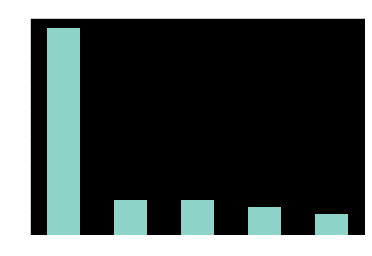

In [6]:
dataset["Label"].value_counts().plot.bar()

In [7]:
#dropping timestamps and IPs for quick prototyping
dataset = dataset.select_dtypes(exclude=['object'])

In [8]:
dataset = dataset.astype("float")
dataset["Label"] = dataset["Label"].astype("int")
dataset = dataset.replace([np.inf, -np.inf], np.nan).dropna()

In [32]:
train_df, val_df = train_test_split(dataset, shuffle = True,
                                                    test_size = 0.2,
                                                    random_state = seed)

val_df, test_df = train_test_split(val_df, shuffle = True,
                                                    test_size = 0.5,
                                                    random_state = seed)

In [33]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        super().__init__()
        self.df_data = torch.from_numpy(df.drop("Label", axis = 1).values)
        self.df_labels = torch.from_numpy(df["Label"].values)

    def __len__(self):
        return len(self.df_data)

    def __getitem__(self, index):        
        sample, label = self.df_data[index], self.df_labels[index]

        return sample, label

train_dataset, val_dataset, test_dataset = Dataset(train_df), Dataset(val_df), Dataset(test_df)

In [64]:
batch_size = 32
learning_rate = 0.00005
epochs = 50
# weights = torch.Tensor(
#     [1-(x/sum(label_counts)) for x in label_counts] #weights for an unbalanced dataset
#     ).to(device)

In [71]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from catalyst.data.sampler import BalanceClassSampler


train_dataloader = DataLoader(
            train_dataset,
            #sampler=BalanceClassSampler(labels = train_df["Label"].values, mode = "downsampling"),
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size)

valid_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size)

test_dataloader = DataLoader(
            test_dataset,
            sampler = SequentialSampler(test_dataset),
            batch_size = batch_size)

In [72]:
class Net(nn.Module):
    def __init__(self, input_size = 80):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 1024)
        self.fc3 = nn.Linear(1024, 2048)
        self.fc4 = nn.Linear(2048, 1024)
        self.fc5 = nn.Linear(1024, 512)
        self.fc6 = nn.Linear(512, 5)    
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)

        return x

net = Net().to(device)

In [73]:
import copy
loss_function = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr = learning_rate, weight_decay = 0.999, betas = (0.9, 0.999))

def training_loop(epochs = epochs, net = net):
    best_model_wts = copy.deepcopy(net.state_dict())
    best_loss = 100
    
    for epoch in (range(epochs)):
        print(f'Epoch {epoch+1}')
        train_losses, train_accuracies = train(net)        
        val_losses, val_accuracies = validate(net)        
        print(f'Training accuracy:   {sum(train_accuracies)/len(train_accuracies)} | Training loss: {sum(train_losses)/len(train_losses)}')
        print(f'Validation accuracy: {sum(val_accuracies)/len(val_accuracies)} | Validation loss: {sum(val_losses)/len(val_losses)}')
        
        epoch_val_loss = sum(val_losses)/len(val_losses)
        
        if best_loss > epoch_val_loss:    
            best_loss = epoch_val_loss
            best_model_wts = copy.deepcopy(net.state_dict())
            torch.save(net.state_dict(), 'best.pth')
            print('saving with loss of {}'.format(epoch_val_loss), 'improved over previous {}'.format(best_loss))

In [74]:
def fwd_pass(X, y, step, train = False):           
    outputs = net(X)
    matches = [torch.argmax(i) == j for i, j in zip(outputs,y)]        
    acc = matches.count(True)/len(matches)
    loss = loss_function(outputs, y)
    if train:
        loss.backward()        
        optimizer.step()        
        optimizer.zero_grad()
    return acc, loss

def train(net):
    net.train()
    train_losses = []
    train_accuracies = []
    print("Training")
    for step, batch in (enumerate(train_dataloader)):
        inputs = batch[0].to(device).float()
        labels = batch[1].to(device).long()    
        acc, loss = fwd_pass(inputs, labels, step, train = True)
        if step > 0 and step % 500 == 0:            
            print(f"Step {step} of {len(train_dataloader)}, Accuracy: {sum(train_accuracies)/len(train_accuracies)}, Loss: {sum(train_losses)/len(train_losses)}")
               
        train_losses.append(loss)
        train_accuracies.append(acc)
    return train_losses, train_accuracies               
                
def validate(net):    
    net.eval()
    val_losses = []
    val_accuracies = []
    print("Validation")
    for step, batch in enumerate(valid_dataloader):            
        valid_inputs = batch[0].to(device).float()
        valid_labels = batch[1].to(device).long()
    with torch.no_grad():
        val_acc, val_loss =  fwd_pass(valid_inputs, valid_labels, step, train = False)
        
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)        
    return val_losses, val_accuracies

In [70]:
training_loop()

Epoch 1
Training
Step 500 of 21263, Accuracy: 0.3603125, Loss: 5319.02880859375
Step 1000 of 21263, Accuracy: 0.37621875, Loss: 3193.640380859375
Step 1500 of 21263, Accuracy: 0.387125, Loss: 2285.2265625
Step 2000 of 21263, Accuracy: 0.394484375, Loss: 1768.8341064453125
Step 2500 of 21263, Accuracy: 0.4007625, Loss: 1444.71630859375
Step 3000 of 21263, Accuracy: 0.40503125, Loss: 1220.5677490234375
Step 3500 of 21263, Accuracy: 0.4091875, Loss: 1054.768798828125
Step 4000 of 21263, Accuracy: 0.41203125, Loss: 930.52392578125
Step 4500 of 21263, Accuracy: 0.4157986111111111, Loss: 830.6005859375
Step 5000 of 21263, Accuracy: 0.4205875, Loss: 749.8562622070312
Step 5500 of 21263, Accuracy: 0.42382386363636365, Loss: 682.7369384765625
Step 6000 of 21263, Accuracy: 0.426765625, Loss: 626.668701171875
Step 6500 of 21263, Accuracy: 0.42936057692307694, Loss: 579.129150390625
Step 7000 of 21263, Accuracy: 0.43163392857142857, Loss: 538.4622192382812
Step 7500 of 21263, Accuracy: 0.433758333

KeyboardInterrupt: 

In [14]:
net.load_state_dict(torch.load("best.pth"))

<All keys matched successfully>

In [16]:
def test_f1():
    pred_labels = None
    true_labels = None

    for batch in test_dataloader:
        preds = net(batch[0].float().to(device))
        preds = preds.cpu().detach().numpy()
        #print(preds)
        trues = batch[1].cpu().detach().numpy()
        if pred_labels is not None:
            pred_labels = np.concatenate((pred_labels, preds), axis=0)
        else:
            pred_labels = preds
        
        if true_labels is not None:
            true_labels = np.concatenate((true_labels, trues), axis=0)
        else:        
            true_labels = trues

    pred_labels = [np.argmax(i) for i in pred_labels]
    score = f1_score(true_labels, pred_labels, average='weighted')

    return score


In [24]:
print(f"Weighted f1 score over 5 labels is: {test_f1}")

0.731272237541192